# Neuro DS Midterm
This midterm will cover the material that we discussed in the first 5 weeks of class. It will take the methods that we've covered thus far into a new dataset, in order to see if there is something that we can learn from the reults.

# Remember
* Make sure you use `%matplotlib inline` before calling any plots that aren't interactive. When you upload a PDF of the midterm, we *need* to see the plots.
* When you're writing code, don't make the code extend beyond the visible code block. If you need to write more, hit enter and continue on the next line. If you're writing a comment (e.g. answering a conceptual question), then just start a new line.
* to submit this homework, **submit both a PDF and the raw jupyter notebook file** to the assignment page on bCourses

# The Dataset
The dataset that we'll use comes from a (different) electrocorticography patient. The subject had intractible epilepsy, which required surgery in order to address. A common problem with neurosurgery is that we don't know *exactly* which regions of the brain are crucial for performing some function. For example, we may know the general region that processes to sounds, but in each individual it'll be a little difference.

To deal with this, doctors often use *localizers* to determine where a particular region is in one person. This surgeon in particular was interested in a region of the brain called the *Fusiform Face Area* (FFA), a well-studied part of the visual system that seems to be particularly responsive to faces. If the surgeon cut this region out, it could make big problems for the patient.

So, the surgeon presented a number of visual stimuli for the patient to look at. They placed a strip of electrodes over the general area where we'd expect the patient's FFA to be (along with a larger grid over the right hemisphere). The subject viewed images of faces as well as objects.

Here are examples of two potential visual stimuli:

Face:
<img src="http://pngimg.com/upload/face_PNG5660.png" alt="face" style="width: 100px;"/>

Object:
<img src="http://i74.photobucket.com/albums/i241/cmucam/Black_Stapler_zpsc3024407.jpg" alt="object" style="width: 100px;"/>


Our task will be to analyze the data collected from these two types of visual stimuli, in order to determine if we can identify the electrode that corresponds to the Fusiform Face Area.

First, let's take a look at our ECoG grid to see where these electrodes are located...

In [1]:
import mne
import neurods as nds
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datascience as ds
%matplotlib notebook

We'll load the raw data that we'll use today...

In [30]:
# --- Set path ---
path_data = '../data/proc/'
# --- Raw data ---
raw = mne.io.Raw(path_data + 'ecog-raw.fif', preload=True)

# --- Event time information ---
# As a pandas dataframe
mtime = pd.read_csv(path_data + 'meta_time.csv', index_col=0)
# Or as a datascience table (use whichever you like)
mtime_tab = ds.Table.read_table(path_data + 'meta_time.csv', index_col=0)

# --- Image and layout of the electrode grid ---
im = plt.imread(path_data + 'brain.png')
melec = pd.read_csv(path_data + 'meta_elec.csv', index_col=0)
layout = mne.channels.read_layout('channel_layout.lout', '../data/proc/',
                                  scale=False)

And then make a quick plot of all the electrodes for this ECoG patient.

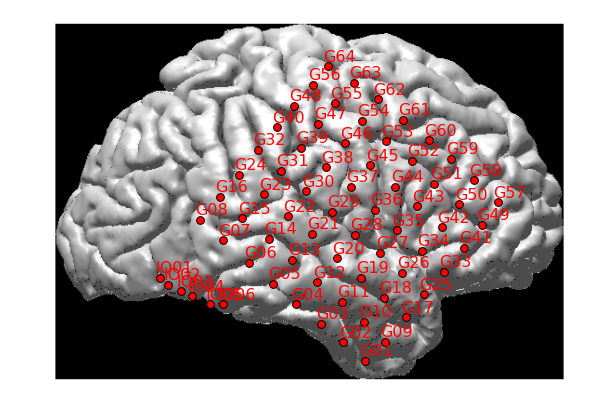

In [24]:
%matplotlib inline
def plot_ecog_layout(layout, im, textcolor='r'):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(im)
    for _, (ch, _, x, y) in  melec.iterrows():
        ax.scatter(x, y, c='r', s=60)
        ax.annotate(ch, (x, y), (x-5, y-5),
                    rotation=0, fontsize=16, color=textcolor)
#     _ = plt.setp(ax.lines, visible=False)
#     _ = plt.setp(ax.texts, size=16, color='r')
    ax.set_axis_off()
    return fig
fig = plot_ecog_layout(layout, im)

In [4]:
# Don't forget you can switch on interactive mode with:
%matplotlib notebook

# And inline mode with:
# %matplotlib inline

As you can see, most of the grid covers the right hemisphere, however that strip to the bottom left is important. It's the one that we think covers the FFA.

# Loading and plotting raw data
First, we need to get a high-level view of the dataset and drop any channels that look bad.

* Plot the raw data we've loaded above. Scan through the entire session of data.
* There is a noisy channel in there, mark its channel name, and put it in a list.
* Finally, drop the channel from the ecog data.

<IPython.core.display.Javascript object>


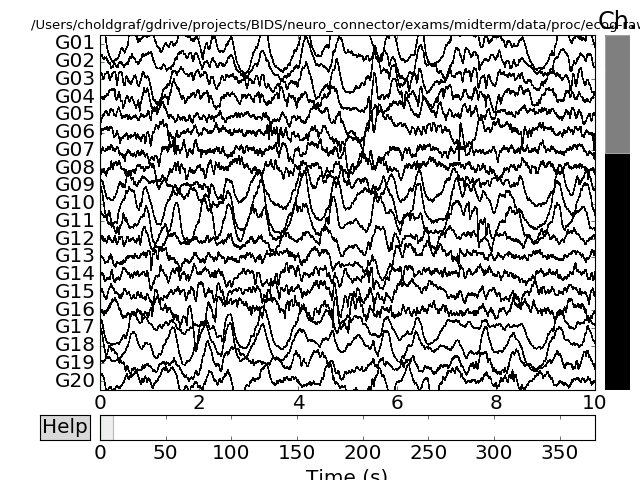

In [5]:
### STUDENT ANSWER
_ = raw.plot()

In [25]:
# Put your noisy channel in a list (and drop it), here:

### STUDENT ANSWER
drop_chan = ['G23']
raw.drop_channels(drop_chan)

ValueError: Channel(s) G23 not found, nothing dropped.

Now that we've got clean channels, it's time to calculate the evoked activity in response to each type of visual stimulus. The visual stimuli are coded like this:

- Faces : 7
- Objects : 3

We'll use event timing information in order to slice up our data and visualize how the brain responds to the pictures:

* Create an MNE events array using the time information in `mtime`.
    * Create one vector of event onsets in samples. Note that the event onsets in `mtime` are in seconds, not samples.
    * Create a dictionary that maps the event type names (faces and objects) onto unique event type integers (7 and 3)
    * Extract from mtime the vector that has one event type integer per event, which designates what event type that event was.
    * Create a vector of 0s that has the same length as the above two vectors.
    * Combine these three things into an MNE events array of shape `(n_events, 3)`
    * Make sure that this array has a dtype of `int`

In [27]:
### STUDENT ANSWER
# ID Dictionary
event_id = {'object': 3, 'face': 7}

# Convert to samples
event_ixs = mtime_tab['start'] * raw.info['sfreq']
zeros = np.zeros_like(event_ixs)
ids = mtime['trial_type']
events = np.vstack([event_ixs, zeros, ids]).T.astype(int)
events[:5]

array([[12510,     0,     3],
       [13020,     0,     3],
       [15068,     0,     3],
       [15578,     0,     3],
       [16088,     0,     3]])

# Epochs ERPs
Now that we have event times in a form MNE can use, let's look at the evoked activity.

* Make a copy of the `Raw` object (using the `.copy()` method).
* Filter this copy between 1 and 30 Hz
* Using the events array above, turn the `Raw` object into an `Epochs` object.
  * Include times from -.3 to .8 seconds
  * Include a baseline from -.3 to -.05 seconds (use the `baseline` parameter)
  * Make sure to include the event ID dictionary you created above

In [40]:
### STUDENT ANSWER
# First filter between 1Hz and 30Hz
raw_ep = raw.copy()
raw_ep.filter(1, 30)

# Now create epochs
epochs = mne.Epochs(raw_ep, events, event_id, tmin=-.3, tmax=.8,
                    baseline=(-.3, -.05))
epochs.save(path_data + 'epochs_filt-epo.fif')

Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


In case you weren't able to create the epochs data above, here we are loading the correct epochs data below. You can use this to continue.

In [44]:
epochs = mne.read_epochs(path_data + 'epochs_filt-epo.fif')

* Create an MNE `Evoked` object by using the `average` method of the `Epochs` object.
  * Create one `Evoked` object for each event type.

In [45]:
av1 = epochs['object'].average()
av2 = epochs['face'].average()

Now let's look at the evoked activity:
* Plot a topomap of the evoked activity using `mne.viz.plot_evoked_topo`.
    * Use the layout supplied above as the input to the `layout` parameter,  and the image of the brain given above as the `fig_background` parameter.

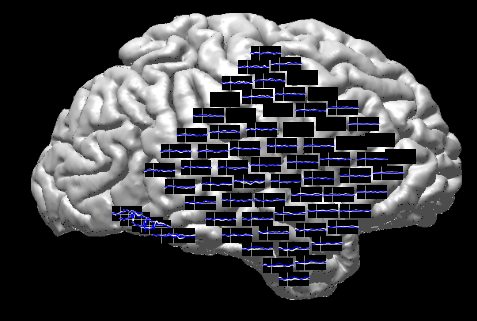

In [46]:
%matplotlib inline
### STUDENT ANSWER
_ = mne.viz.plot_evoked_topo([av1, av2], layout=layout, fig_background=im)

* Create a visualization of some individual channels. Try looking at the ERP for channels 'IO02' and 'IO03' (at indices 55 and 56).
  * To do this, use the function `mne.viz.plot_compare_evokeds`, this will plot the evoked activity in each condition for that channel.
  * This function will take a dictionary where each key is the name of an event type, and the value is an `Evoked` object. E.g.: `dict(event_type_1=av_1, event_type_2=av_2)`. It is also to simply pass a list of `Evoked` objects.
  * Note: You can plot an individual channel using the `picks` parameter...note that it requires a list of integers, specifying channel indices.

In 0.13 the default is weights="nave", but in 0.14 the default will be removed and it will have to be explicitly set


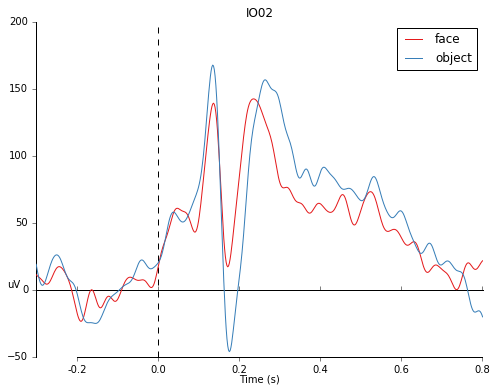

In 0.13 the default is weights="nave", but in 0.14 the default will be removed and it will have to be explicitly set


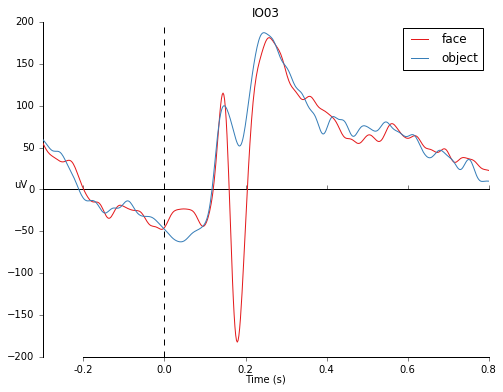

In [68]:
%matplotlib inline
ixs_plt = [55, 56]

### STUDENT ANSWER
for ix in ixs_plt:
    _ = mne.viz.plot_compare_evokeds({'object': av1, 'face': av2}, picks=[ix])

* Does it seem like there are differences between these two conditions in either of these two electrodes? Why or why not?

In [11]:
### STUDENT ANSWER

# Time-frequency representation
Maybe there are some differences, but it's hard to tell. Let's turn to a signal in the data that is much more closely-tied to brain activity: high-frequency activity.

* Make another copy of the `Raw` data.
* Use this copy along with the event timings to create another `Epochs` object from the raw data, this time without any filtering of the raw data first.

In [47]:
### STUDENT ANSWER
raw_tfr = raw.copy()
epochs = mne.Epochs(raw_tfr, events, event_id,
                    tmin=-.3, tmax=.5, preload=True)
epochs.save(path_data + 'epochs_tfr-epo.fif')

Again, in case you weren't able to do this correctly, here's the data that you should now have:

In [48]:
epochs = mne.read_epochs(path_data + 'epochs_tfr-epo.fif')

* Then, use morlet wavelets to create a time-frequency representation of the `Epochs` data.
* **for each event type**:
    * You should use the `tfr_morlet` function
    * Use 50 linearly-spaced frequencies from 10 to 150 Hz (use the `np.linspace` function.)
    * Use `n_cycles=5`.
    * Remember you can take a subset of the epochs belonging to a single event type by passing it as a string to the `epochs` object, e.g. `epochs['my_event_type']`

In [49]:
### STUDENT ANSWER
freqs = np.linspace(10, 150, 50)
tfr_face = nds.tfr.tfr_morlet(epochs['face']._data, epochs.info['sfreq'], freqs,
                              n_cycles=5.)
tfr_object = nds.tfr.tfr_morlet(epochs['object']._data, epochs.info['sfreq'], freqs,
                               n_cycles=5.)

100%|██████████| 40/40 [00:14<00:00,  2.55it/s]


* Calculate mean TFR for each condition by averaging across trials
* then use the result to create an `AverageTFR` object for each condition.

In [50]:
### STUDENT ANSWER
# Calculate the average TFR w/in each condition
tfr_a_1 = tfr_face.mean(0)
tfr_a_2 = tfr_object.mean(0)

tfr_a_1 = mne.time_frequency.AverageTFR(epochs.info, tfr_a_1, epochs.times, freqs, epochs._data.shape[0])
tfr_a_2 = mne.time_frequency.AverageTFR(epochs.info, tfr_a_2, epochs.times, freqs, epochs._data.shape[0])

* Now, make a topographic map of the TFR for each condition.
    * Use the `plot_topo` method of the `AverageTFR` object you've created. 
    * Use a baseline of `(None, 0)`
    * set `mode='zscore'`
    * set the vmin/vmax to -3 and 3
    * Don't forget to set the image of the brain as the `fig_background`.

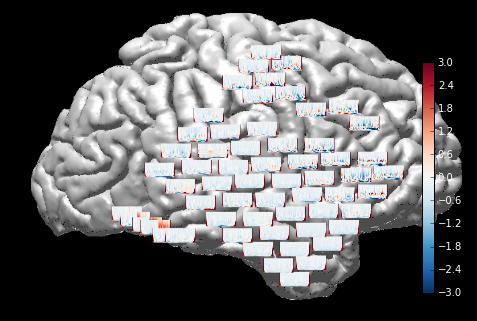

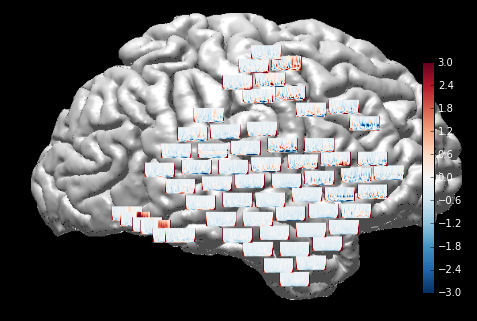

In [52]:
%matplotlib inline
vmin, vmax = -3, 3
### STUDENT ANSWER
_ = tfr_a_1.plot_topo(picks=range(len(tfr_a_1.ch_names)), layout=layout,
                      baseline=(None, 0), mode='zscore', vmin=vmin, vmax=vmax,
                      fig_background=im)

_ = tfr_a_2.plot_topo(picks=range(len(tfr_a_2.ch_names)), layout=layout,
                      baseline=(None, 0), mode='zscore', vmin=vmin, vmax=vmax,
                      fig_background=im)

* Now, calculate the difference between the two `AverageTFR` objects (you can directly subtract the two).
* Make a topo plot of this result as well.

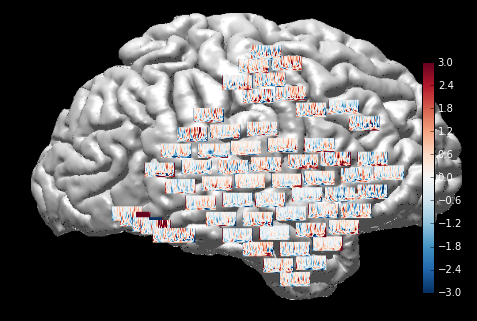

In [53]:
%matplotlib inline
### STUDENT ANSWER
diff = tfr_a_2 - tfr_a_1
_ = diff.plot_topo(picks=range(len(diff.ch_names)), layout=layout,
                   baseline=(None, 0), mode='zscore', vmin=vmin, vmax=vmax,
                   fig_background=im)

It looks like those electrodes over FFA seem to be doing something. Let's investigate further.

* Make a TFR plot of channels "IO02" and "IO03" for the difference between the two conditions (the same ones we just plotted above).
  * Use the `plot` method of the `AverageTFR` obects.
  * Set the mode to `'zscore'`, the baseline to `(None, 0)`, and the vmin/vmax to -10 and 10, respectively.

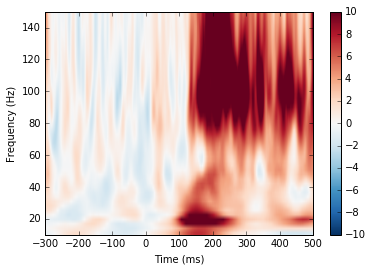

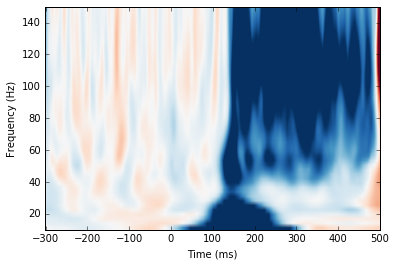

In [57]:
mode = 'zscore'
baseline = (None, 0)
vmin, vmax = -10, 10
### STUDENT ANSWER
_ = diff.plot(ixs_plt, baseline=baseline, mode=mode, vmin=vmin, vmax=vmax)

* How do the differences between these TFRs compare with the ERPs that we calculated earlier?

In [60]:
### STUDENT ANSWER
# There should be a reversal in the direction of the TFR for these two
# electrodes. One has a bigger response for faces, the other has a bigger
# response for objects. This is similar to the fact that ERPs showed opposite
# trends (in terms of which line was above the other), but this is easier
# to interpret.

# High-frequency amplitude
It looks like the majority of the differences are in the high-frequencies (>40Hz or so). Let's focus on that and look at the effects.

* On the raw data, use the `nds.tfr.extract_amplitude` function to extract 10 linearly-spaced frequencies from 70 to 150 Hz. (use `np.linspace`)
* Then create an `Epochs` object from this high-frequency ampitude using the same event times above.

In [61]:
### STUDENT ANSWER
freqs = np.linspace(70, 150, 10)
hfa = nds.tfr.extract_amplitude(raw, freqs)
epochs_hfa = mne.Epochs(hfa, events, event_id, tmin=-.3, tmax=.5)
epochs_hfa.save(path_data + 'epochs_hfa-epo.fif')

100%|██████████| 10/10 [00:25<00:00,  2.69s/it]


In case you were not able to create the epochs and extract high-frequency amplitude above, here is the epochs file that you'll need to finish this section:

In [62]:
epochs_hfa = mne.read_epochs(path_data + 'epochs_hfa-epo.fif')

* Create an `Evoked` object for each condition type.
* Calculate the difference between the two `Evoked` objects
* Plot this difference as a topo plot on the brain

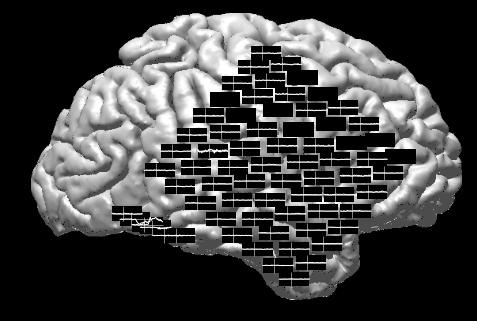

In [67]:
%matplotlib inline
### STUDENT ANSWER
av_face = epochs_hfa['face'].average()
av_object = epochs_hfa['object'].average()
diff = av_face - av_object
_ = diff.plot_topo(layout=layout, fig_background=im)

It looks like the two electrodes to the bottom left are again showing the only effects. Let's take a look at them:

* Finally, use the `mne.viz.plot_compare_evokeds` function to compare the evoked high-frequency activity between the two conditions for an electrode.
  * Do this for the two electrodes we visusalized above.

In 0.13 the default is weights="nave", but in 0.14 the default will be removed and it will have to be explicitly set


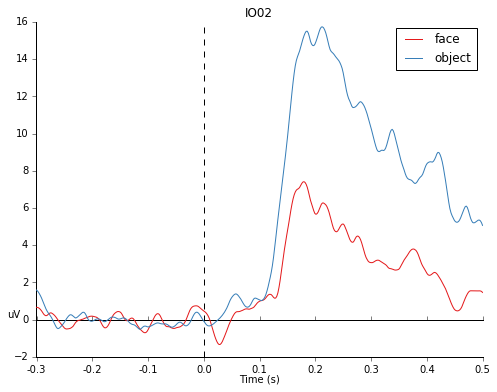

In 0.13 the default is weights="nave", but in 0.14 the default will be removed and it will have to be explicitly set


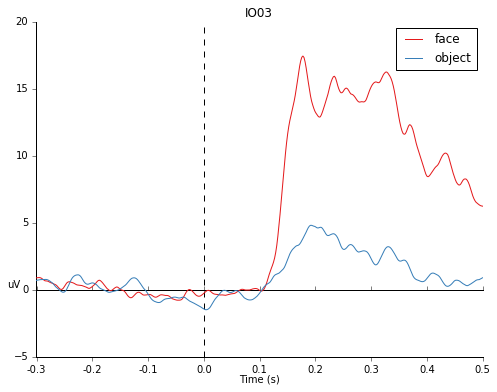

In [63]:
%matplotlib inline
### STUDENT ANSWER
for ix in ixs_plt:
    _ = mne.viz.plot_compare_evokeds({'face': av_face, 'object': av_object},
                                     picks=[ix])

# Extra credit - Comparing variance
As a bonus, let's compre how noisy the raw ERPs are compared with the evoked high-frequency activity. Below we'll load the `Epochs` objects associated with each one, and take a subset of trials corresponding to faces:

In [79]:
epochs_hfa = mne.read_epochs(path_data + 'epochs_hfa-epo.fif', preload=True)
epochs_hfa = epochs_hfa['face'].crop(-.2, .5)

epochs_raw = mne.read_epochs(path_data + 'epochs_filt-epo.fif', preload=True)
epochs_raw = epochs_raw['face'].crop(-.2, .5)

* For each `Epochs` object, calculate its mean **and** its standard error across trials. You can use the `nds.stats.standard_error` function.

In [80]:
### STUDENT ANSWER
mean_hfa = epochs_hfa._data.mean(axis=0)
se_hfa = nds.stats.standard_error(epochs_hfa._data, axis=0)

mean_raw = epochs_raw._data.mean(axis=0)
se_raw = nds.stats.standard_error(epochs_raw._data, axis=0)

* Finally, for the two active electrodes that we plotted above, make a plot showing the mean +/- the standard error for each data type (one for HFA, one for raw data).
  * Plot the raw data with `ax1` and the HFA data with `ax2`.
  * use the `ax.fill_between` function. This will accept a vector of x-values to plot (the `times` in our epochs objects), a vector of lower y-values to plot (the mean - the standard error), and a vector of upper y-values to plot (the mean + the standard error)

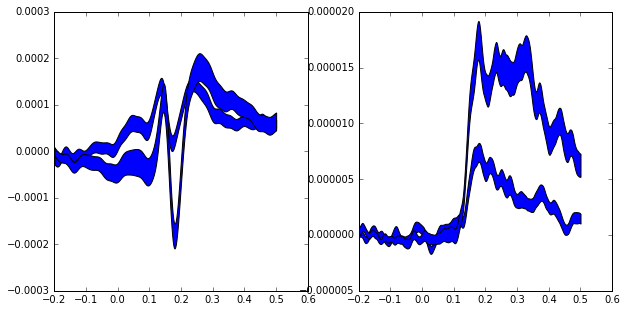

In [82]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

### STUDENT ANSWER
for ix in ixs_plt:
    ax1.fill_between(epochs_raw.times, mean_raw[ix] - se_raw[ix],
                    mean_raw[ix] + se_raw[ix])
    ax2.fill_between(epochs_hfa.times, mean_hfa[ix] - se_hfa[ix],
                    mean_hfa[ix] + se_hfa[ix])

* Which type of data seems to have a more clear difference between the two conditions?

In [83]:
### STUDENT ANSWER